In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from IPython.display import display, clear_output
import ipywidgets as widgets
import pickle

from utils.placecell_functions import *
from utils.placecell_ploting import *
from utils.placecell_classes import data_loader, animal_widgets

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
data_dir = "../data/"
save_location = "../output_data/"
output_dir = "../output_figs/"

exp_sets = ['mcherry']
data_sets = ['Day2 - Squ-Tri-Tri','Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-Tri', 'Day6 - Tri-OptoHex-Hex']

data_titles = ['Day2 - Familiar - Novel - Novel','Day4 - Familiar - Familiar - Familiar', 'Day5 - Familiar - OptoFamiliar - Familiar', 'Day6 - Familiar - OptoNovel - Novel']
session_names = [["Familiar", "Novel", "Novel"],["Familiar", "Familiar", "Familiar"],["Familiar", "OptoFamiliar", "Familiar"],["Familiar", "OptoNovel", "Novel"]]

data_filenames = ['ratemap_structure_day2.mat','ratemap_structure_day4.mat','ratemap_structure_day5.mat','ratemap_structure_day6.mat']


opto_actual_bins = [8, 20] #These are the zones that contained opto frames but the edges hardly had any
control_actual_bins = [21, 33] #This is the oposite of that zone. 
opto_bins = [10,18] # inclusive and based on zero index (added +1 when indexing)
control_bins = [21,29] # inclusive and based on zero index (added +1 to second element when indexing)


# colour palettes used for the plotting
purple_green_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.9411764705882353, 0.5607843137254902, 0.2901960784313726)]

purple_green_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.9490196078431372, 0.6784313725490196, 0.45098039215686275)]


joint_pal = [purple_orange_pallette, purple_green_pallette]
joint_pal_point = [purple_orange_pallette_point, purple_green_pallette_point]


### Define and show widgets
Using ipython widgets create and show widgets for data display option
- Could add observers for each widget to run the data processing step

In [4]:
# callback function to redraw widgets when dataset changes
def update_widgets(change):
    animals.create_widget(output_widget)
    

sort_by = widgets.RadioButtons(
        options=['Session 1', 'Session 2', 'Session 3'],
        index = 1,
        description='Ratemap to align to:',
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    )

activity_type = widgets.Select(
                options=["All activity","Place activity"],
                index=0,
                rows = 2,
                description='Activity type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )

show_opto = widgets.Checkbox(
            value=False,
            description='Show optozone',
            disabled=False,
            indent=False
        )

ratemap_type = widgets.Select(
                options=["All cell rates","Place cells"],
                index=0,
                rows = 2,
                description='Ratemap type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )


# create an instance of the data loader
data = data_loader(data_dir, exp_sets, data_sets, data_filenames, data_titles, session_names)

# observe when the data object changes
data.data_widget.observe(update_widgets, names = 'value')

#create an output widget that will hold the FOV image or the selection widget
output_widget = widgets.Output() 

#create animals widgets
animals = animal_widgets(output_widget, data)

#display all of the widgets
display(data.exp_widget)
display(data.data_widget)
display(animals.create_widget(output_widget)) 
display(activity_type)
display(ratemap_type)
display(sort_by)
display(show_opto)


RadioButtons(description='Experiments:', options=('mcherry',), value='mcherry')

RadioButtons(description='Dataset:', options=('Day2 - Squ-Tri-Tri', 'Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-…

Output()

Select(description='Activity type:', options=('All activity', 'Place activity'), rows=2, style=DescriptionStyl…

Select(description='Ratemap type:', options=('All cell rates', 'Place cells'), rows=2, style=DescriptionStyle(…

RadioButtons(description='Ratemap to align to:', index=1, options=('Session 1', 'Session 2', 'Session 3'), val…

Checkbox(value=False, description='Show optozone', indent=False)

### Process the data for plotting

In [15]:
# get widgets values and process data
animal_id = animals.selection.value
ids_to_pool = animals.ids_to_pool.value
sort_by_index = sort_by.index
compare_to_place = activity_type.index
plot_opto = show_opto.value

placecell_rates_dict = data.placecell_rates_dict
placecell_info_dict = data.placecell_info_dict

raw_rates_dict = data.raw_rates_dict
#raw_rates_info_dict = data.allcell_info_dict

sub_titles = data.sub_titles
data_set_to_plot = data.data_set_to_plot
title_for_data = data.title_for_data 
display_placecells = ratemap_type.index


# Select which data to be included in analysis
if animal_id == 'pooled data':
    #concatonate all of the animals ontop of eachother into a list
    placecell_rates = create_pooled_data(placecell_rates_dict,ids_to_pool)
    placecell_spatial_info = create_pooled_data(placecell_info_dict,ids_to_pool)
    raw_rates = create_pooled_data(raw_rates_dict,ids_to_pool)
    rates_average, rates_sem = get_pooled_average_rates(raw_rates_dict,ids_to_pool)
    coors_diags_mean, coors_diags_sem, opto_zone_diag, ctrl_zone_diag, opto_zone_avg, control_zone_avg = get_pooled_avg_corrs(raw_rates_dict,
                                                                                                                              placecell_rates_dict,
                                                                                                                              sort_by_index,
                                                                                                                              compare_to_place,
                                                                                                                              ids_to_pool,
                                                                                                                              opto_bins,
                                                                                                                              control_bins)
else:
    placecell_rates = placecell_rates_dict[animal_id]
    raw_rates = raw_rates_dict[animal_id]
    rates_average = get_average_rates(raw_rates_dict,animal_id)


# sort the ratemaps based on the user input
compare_rates = placecell_rates[sort_by_index]
sort_id, sort_index = sort_ratemaps(compare_rates)

# using the indices of sort_id Sort each placecell and rawrates  DataFrames in the list of dataframes and s and convert 
place_rates_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_rates]
raw_rates_sorted = [df.reindex(sort_id).fillna(0) for df in raw_rates]
spatial_info_sorted = [df.reindex(sort_id).fillna(0) for df in placecell_spatial_info]

#get the placefield center for sorted ratemaps
place_rates_sorted_centers = [get_placecell_centers(df) for df in place_rates_sorted]
raw_rates_sorted_centers = [get_placecell_centers(df) for df in raw_rates_sorted]


# Proccess which rate maps to display          
if compare_to_place:
    display_rates = place_rates_sorted
else:
    display_rates = raw_rates_sorted
    display_rates[sort_by_index] = place_rates_sorted[sort_by_index]

# create the arrays to used for correlation
array1 = display_rates[sort_by_index].values
array2 = [df.values for df in display_rates]

# create the population vector correlation
place_rates_popveccorr = [create_corr_matrix(array1,array2[i]) for i in range(len(array2))]

# create the spatial correlation
place_rates_spatialcorr = [spatial_corr(array1,array2[i]) for i in range(len(array2))]


if animal_id != 'pooled data':

    coors_diags_mean = [np.diagonal(corrs) for corrs in place_rates_popveccorr]
    opto_zone_avg = [[np.mean(corrs[opto_bins[0]:opto_bins[1]+1,opto_bins[0]:opto_bins[1]+1])] for corrs in place_rates_popveccorr]
    control_zone_avg = [[np.mean(corrs[control_bins[0]:control_bins[1]+1,control_bins[0]:control_bins[1]+1])] for corrs in place_rates_popveccorr]

    opto_zone_diag = [[np.nanmean(id[opto_bins[0]:opto_bins[1]+1])] for id in coors_diags_mean]
    ctrl_zone_diag = [[np.nanmean(id[control_bins[0]:control_bins[1]+1])] for id in coors_diags_mean]


if display_placecells:
    rates_to_plot =  sort_placecells(placecell_rates)
else:
    rates_to_plot = display_rates



ctrl_zone_diag_display = ctrl_zone_diag.copy()
ctrl_zone_diag_display.pop(sort_by_index)

opto_zone_diag_display = opto_zone_diag.copy()
opto_zone_diag_display.pop(sort_by_index)




c:\Users\Matt\anaconda3\envs\placecell_processing\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Matt\anaconda3\envs\placecell_processing\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.9999999999999998)]

# Create group plots from multiple data sets
- run the following cell once to create empty lists and then comment out
- change the dataset via widget and re-run processing and add datasets to list
- plot the resulting grouped plot

In [9]:
# run just once and then comment out
average_pop_corrs_control = []
average_pop_corrs_opto = []

In [16]:
corr_index = 1 # session index for the correlation (sort by session is already removed)

# append the data to the grouped data list
average_pop_corrs_control.append(ctrl_zone_diag_display[corr_index])
average_pop_corrs_opto.append(opto_zone_diag_display[corr_index])

# reload the next dataset from the widget and reprocess the data. Append the next dataset to the above list

In [19]:
np.save(save_location + 'pop_vector_bars\\mcherry_ctrl_avg_popvec.npy', average_pop_corrs_control)
np.save(save_location + 'pop_vector_bars\\mcherry_opto_avg_popvec.npy', average_pop_corrs_opto)

In [21]:
mcherry_pop_corrs_control = np.load(save_location+ 'pop_vector_bars\\mcherry_ctrl_avg_popvec.npy')
mcherry_pop_corrs_opto = np.load(save_location + 'pop_vector_bars\\mcherry_opto_avg_popvec.npy')

In [22]:
purple_green_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.9411764705882353, 0.5607843137254902, 0.2901960784313726)]

purple_green_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.9490196078431372, 0.6784313725490196, 0.45098039215686275)]


joint_pal = [purple_green_pallette, purple_orange_pallette]

joint_pal_point = [purple_green_pallette_point, purple_orange_pallette_point]

In [23]:
joint_pal = [['#693ca3', '#3ebec9'], ['#693ca3', '#eb6c9c']]
joint_pal_point = [['#7c5fa3', '#abeff5'], ['#7c5fa3', '#e38dae']]

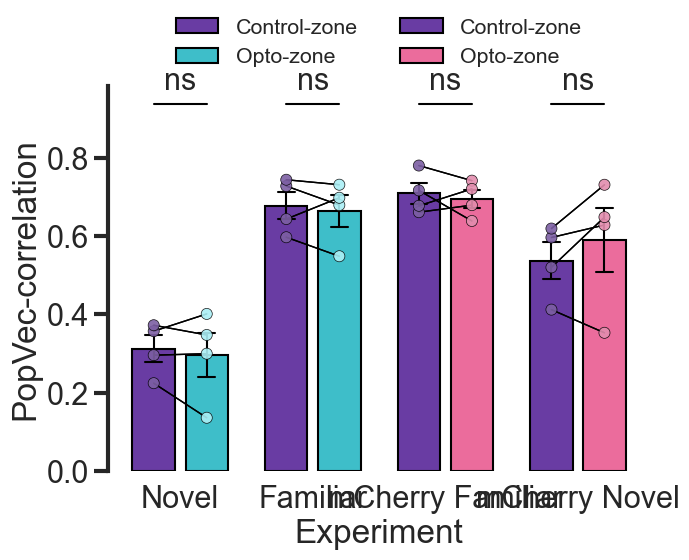

In [26]:
opsins_pop_corrs_opto_nov = mcherry_pop_corrs_opto
opsins_pop_corrs_ctrl_nov = mcherry_pop_corrs_control

def strip_id(id):
    id = str(id)
    animal = id[0:4]
    return animal

y_data_control = opsins_pop_corrs_ctrl_nov
y_data_opto = opsins_pop_corrs_opto_nov


exp_labels = ["Novel", "Familiar", "mCherry Familiar", "mCherry Novel"]


control_corr_df = pd.DataFrame()
opto_corr_df = pd.DataFrame()
for i in range(len(y_data_control)):
    contorl_temp_df = pd.DataFrame({'PopVec-correlation': pd.Series(y_data_control[i]), 'Experiment': exp_labels[i], 'Zone': 'Control-zone'})
    opto_temp_df = pd.DataFrame({'PopVec-correlation': pd.Series(y_data_opto[i]), 'Experiment': exp_labels[i], 'Zone': 'Opto-zone'})
    control_corr_df = pd.concat([control_corr_df,contorl_temp_df], ignore_index=True)
    opto_corr_df = pd.concat([opto_corr_df,opto_temp_df], ignore_index=True)

pop_corr_melted_df = pd.concat([control_corr_df, opto_corr_df], ignore_index=True)

#pop_corr_melted_df
exp_pvals = []
for exp in exp_labels:
    exp_df = pop_corr_melted_df[pop_corr_melted_df['Experiment'] == exp]
    control_vals = exp_df[exp_df['Zone']=='Control-zone']['PopVec-correlation'].dropna().values
    opto_vals = exp_df[exp_df['Zone']=='Opto-zone']['PopVec-correlation'].dropna().values
    exp_pvals.append(stats.ttest_rel(control_vals,opto_vals)[1])

exp_pval_stars = [get_significance_stars(p_val) for p_val in exp_pvals]

fig = plot_paired_box(pop_corr_melted_df, x = "Experiment", y = "PopVec-correlation", 
                          plot_type = 'barplot',
                          stats = exp_pval_stars, group = "Zone", show_ns=True, fontsize_scale=2.0,
                          width_scale = 1.75, height = 5.0, pallette = joint_pal,
                         point_pallette = joint_pal_point, 
                         point_alpha= 0.9, group_dv=2)


In [28]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'
save_path = f"../output_figs/pop_vector_bars/mcherry_popvec_correlation.svg"
fig.savefig(save_path, format='svg')